In [1]:
library(ggplot2)

## Preparando Dados

In [2]:
df = read.csv('dados.csv', sep = ';', stringsAsFactors=F)

In [3]:
# substituindo os NAs por -1
df[is.na(df)] = -1

In [4]:
# substituindo ig. por -1
df['ano'] = ifelse(df$ano == 'ig.', -1, df$ano)

In [5]:
# coluna com purpose
# que obteve a soma máxima
df['purpose_with_max_sum'] = ifelse(df$SOMA > df$SOMA.1 &
                            df$SOMA > df$SOMA.2, df$X1_purpose, 
                            ifelse(df$SOMA.1 > df$SOMA &
                                  df$SOMA.1 > df$SOMA.2, df$X2_purpose, df$X3_purpose))

In [6]:
# coluna com a soma máxima
df['purpose_max_sum'] = ifelse(df$SOMA > df$SOMA.1 &
                            df$SOMA > df$SOMA.2, df$SOMA, 
                            ifelse(df$SOMA.1 > df$SOMA &
                                  df$SOMA.1 > df$SOMA.2,df$SOMA.1, df$SOMA.2))

In [7]:
# removendo os sem resposta
df2 = subset(df, purpose_with_max_sum != 'sem_resposta')

## Visualizações 

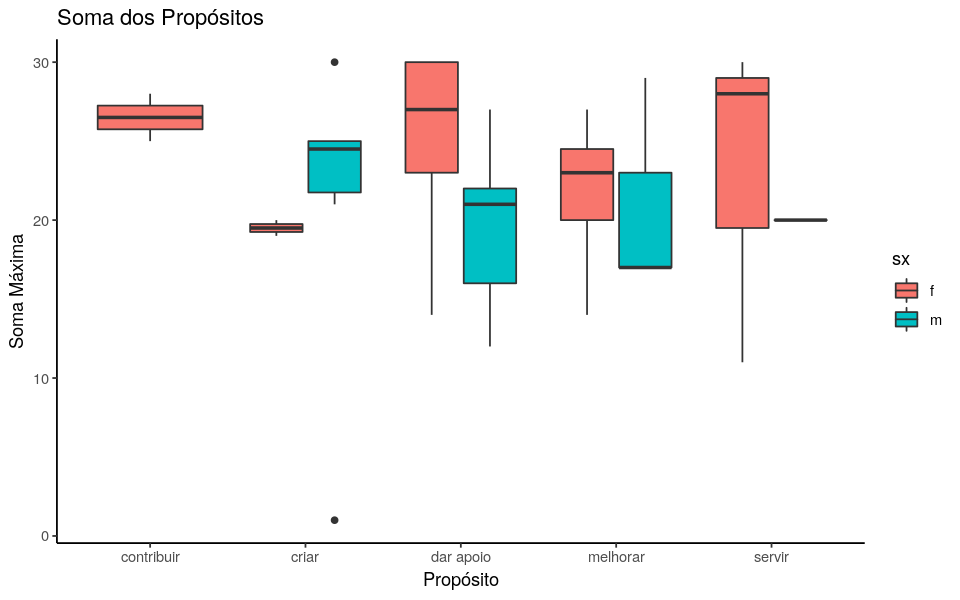

In [8]:
# Change  automatically color by groups
options(repr.plot.width=8, repr.plot.height=5)
bp <- ggplot(df2, aes(x=purpose_with_max_sum, y=purpose_max_sum, fill=sx)) + 
  geom_boxplot()+
  labs(title="Soma dos Propósitos",x="Propósito", y = "Soma Máxima")
bp + theme_classic()

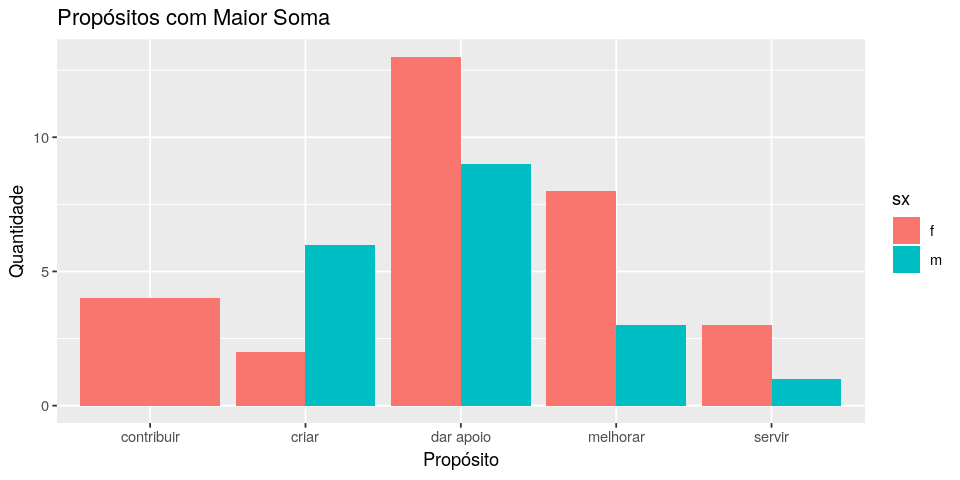

In [9]:
options(repr.plot.width=8, repr.plot.height=4)
ggplot(df2, aes(purpose_with_max_sum, fill = sx)) +
         geom_bar(position = "dodge") +
         xlab('Propósito') +
         ylab('Quantidade') +
         ggtitle('Propósitos com Maior Soma')

In [10]:
p.v = aggregate(df2$P..V., by=list(Category=df2$sx), FUN=sum)

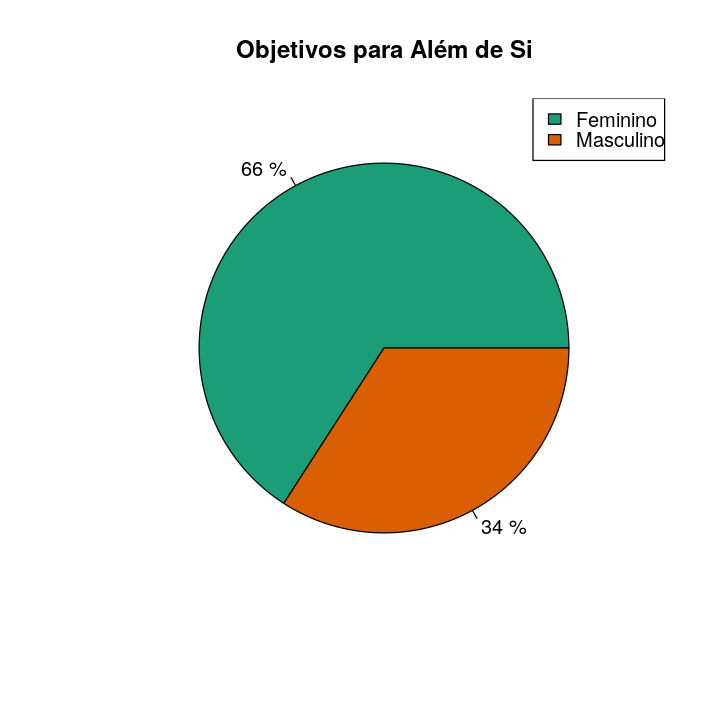

In [11]:
options(repr.plot.width=6, repr.plot.height=6)
pie(p.v$x, paste(round((p.v$x/sum(p.v$x))*100), '%'), main="Objetivos para Além de Si",col=c("#1B9E77","#D95F02"))
legend("topright", c("Feminino","Masculino"),
   fill = c("#1B9E77","#D95F02"))

## Existe uma dependência entre Sexo e Propósito Escolhido?

Vamos usar o teste [Qui-quadrado](https://en.wikipedia.org/wiki/Chi-squared_distribution) para responder essa pergunta. A hipótese nula com este teste é que as duas variáveis categóricas são independentes. A hipótese alternativa é que existe alguma dependência entre as duas categorias.

In [12]:
# Tabela de Contiguência 
tabela = table(df2$sx, df2$purpose_with_max_sum)
tabela

   
    contribuir criar dar apoio melhorar servir
  f          4     2        13        8      3
  m          0     6         9        3      1

In [13]:
# Teste de Qui-quadrado
chisq.test(tabela)

Warning message in chisq.test(tabela):
“Chi-squared approximation may be incorrect”


	Pearson's Chi-squared test

data:  tabela
X-squared = 7.9303, df = 4, p-value = 0.09417


A mensagem de *Warning* dada logo acima pela função *chisq.test()*, indica que o tamanho da amostra é muito pequeno para fazer uma análise estatística significativa.

Para tentar corrigir essa falta de dados vamos adicionar o parâmetro *simulate.p.value = T* , para usar o método de Monte Carlo ao teste, e assim tentar melhorar a estimativa e se livrar da mensagem de aviso. Mas a melhor maneira de se livrar dessa mensagem é obter uma amostra maior.

In [14]:
teste = chisq.test(tabela, simulate.p.value = T)
print(teste)


	Pearson's Chi-squared test with simulated p-value (based on 2000
	replicates)

data:  tabela
X-squared = 7.9303, df = NA, p-value = 0.08946



 Com um nível de significância de 0,05 (probabilidade de erro de 5%), aceitamos a 
 hipótese nula, ou seja, que as variáveis sexo e propósito são independentes. 

## Regras de Associação Entre Propósitos Escolhidos

Iremos usar [Regras de Associação](https://en.wikipedia.org/wiki/Association_rule_learning) para fazer a seguinte análise entre os propósitos: quem escolhe o propósito "A" também costuma escolher o propósito "B" e "C".

In [16]:
library(arules)

In [17]:
# pegando apenas as colunas
# dos propósitos
propositos = df[,c(4, 5, 6)]

In [18]:
# juntando os propósitos
# separados por "-" numa única coluna
propositos['propositos'] = paste(propositos$opcao_1, 
                                 propositos$opcao_2,
                                 propositos$opcao_3,
                                 sep = '-')

In [19]:
# Criando um objeto arules
items <- strsplit(as.character(propositos$propositos), "-")
propositos <- as(items, "transactions")

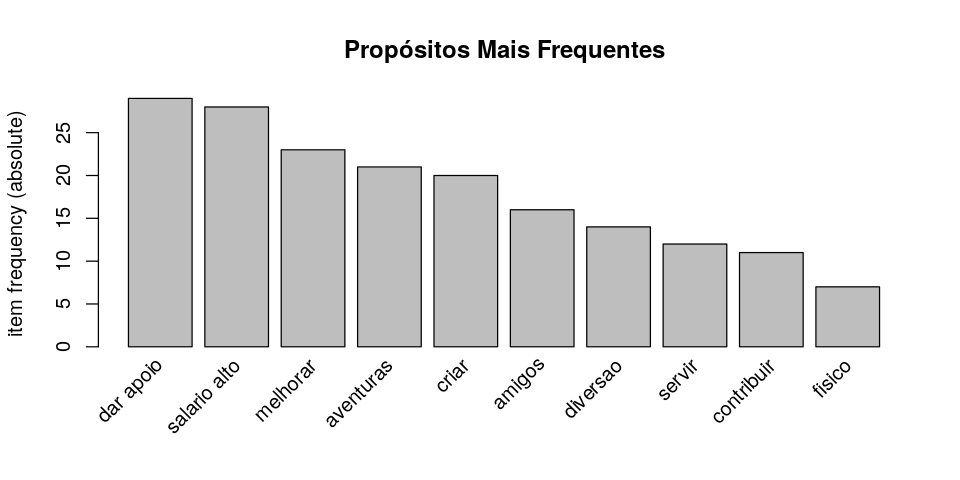

In [20]:
options(repr.plot.width=8, repr.plot.height=4)
itemFrequencyPlot(propositos, topN=10, type="absolute", main="Propósitos Mais Frequentes")

In [21]:
# criando regras de associação
rules <- apriori (propositos, parameter = list(supp = 0.001, conf = 0.5)) 
rules_conf <- sort (rules, by="confidence", decreasing=TRUE)

Apriori

Parameter specification:
 confidence minval smax arem  aval originalSupport maxtime support minlen
        0.5    0.1    1 none FALSE            TRUE       5   0.001      1
 maxlen target   ext
     10  rules FALSE

Algorithmic control:
 filter tree heap memopt load sort verbose
    0.1 TRUE TRUE  FALSE TRUE    2    TRUE

Absolute minimum support count: 0 

set item appearances ...[0 item(s)] done [0.00s].
set transactions ...[12 item(s), 63 transaction(s)] done [0.00s].
sorting and recoding items ... [12 item(s)] done [0.00s].
creating transaction tree ... done [0.00s].
checking subsets of size 1 2 3 done [0.00s].
writing ... [36 rule(s)] done [0.00s].
creating S4 object  ... done [0.00s].


In [22]:
# obtendo subset de rules redundantes
subsetRules <- which(colSums(is.subset(rules, rules)) > 1)

# removendo o subset de rules
# redundantes
rules <- rules[-subsetRules] 

In [23]:
# Resultado das regras
inspect(rules)

     lhs                          rhs            support    confidence lift    
[1]  {}                        => {melhorar}     0.01587302 1.0000000  2.739130
[2]  {apoio}                   => {diversao}     0.03174603 1.0000000  4.500000
[3]  {apoio}                   => {aventuras}    0.01587302 0.5000000  1.500000
[4]  {apoio}                   => {salario alto} 0.01587302 0.5000000  1.125000
[5]  {fisico}                  => {dar apoio}    0.07936508 0.7142857  1.551724
[6]  {servir}                  => {dar apoio}    0.14285714 0.7500000  1.629310
[7]  {diversao}                => {salario alto} 0.12698413 0.5714286  1.285714
[8]  {amigos,fisico}           => {salario alto} 0.01587302 0.5000000  1.125000
[9]  {fisico,melhorar}         => {salario alto} 0.01587302 1.0000000  2.250000
[10] {aventuras,servir}        => {contribuir}   0.01587302 1.0000000  5.727273
[11] {contribuir,diversao}     => {criar}        0.01587302 1.0000000  3.150000
[12] {amigos,contribuir}       => {dar a

In [24]:
# propósitos que levam a 'salário alto'
rules <- apriori (data=propositos, parameter=list (supp=0.001,conf = 0.08), 
                  appearance = list (default="lhs",rhs="salario alto"), 
                  control = list (verbose=F)) 
rules_conf <- sort (rules, by="confidence", decreasing=TRUE) 
inspect(head(rules_conf))

    lhs                     rhs            support    confidence lift     count
[1] {fisico,melhorar}    => {salario alto} 0.01587302 1.0000000  2.250000 1    
[2] {aventuras,diversao} => {salario alto} 0.06349206 0.6666667  1.500000 4    
[3] {diversao}           => {salario alto} 0.12698413 0.5714286  1.285714 8    
[4] {apoio}              => {salario alto} 0.01587302 0.5000000  1.125000 1    
[5] {apoio,diversao}     => {salario alto} 0.01587302 0.5000000  1.125000 1    
[6] {amigos,fisico}      => {salario alto} 0.01587302 0.5000000  1.125000 1    


In [25]:
# propósitos que levam a 'servir'
rules <- apriori (data=propositos, parameter=list (supp=0.001,conf = 0.08), 
                  appearance = list (default="lhs",rhs="servir"), 
                  control = list (verbose=F)) 
rules_conf <- sort (rules, by="confidence", decreasing=TRUE) 
inspect(head(rules_conf))

    lhs                       rhs      support    confidence lift    count
[1] {dar apoio,melhorar}   => {servir} 0.04761905 0.4285714  2.25000 3    
[2] {dar apoio,fisico}     => {servir} 0.03174603 0.4000000  2.10000 2    
[3] {contribuir,dar apoio} => {servir} 0.03174603 0.4000000  2.10000 2    
[4] {aventuras,contribuir} => {servir} 0.01587302 0.3333333  1.75000 1    
[5] {dar apoio}            => {servir} 0.14285714 0.3103448  1.62931 9    
[6] {fisico}               => {servir} 0.03174603 0.2857143  1.50000 2    


## Algumas Ponderações

Algo que seria super interessante ter feito era ter permitido que os alunos pontuassem 
também os propósitos para si, e não somente os além de si. Assim poderíamos validar a seguinte questão: existe dependência entre sexo e objetivos para além de si? 

Essa amostra não permite tirar nenhum tipo de conclusão genérica. Você poderá apenas dizer que, olhando apenas para os objetivos além de si, para os alunos do 1º e 2º ano do ensino médio da escola *X*, os dados dizem isso.